a. Especificaciones de la serie 

In [1]:
import pandas as pd

# Cargar los datos desde el archivo Excel
df_consumo = pd.read_excel("Consumo.xlsx")

# Convertir la columna "Fecha" a formato datetime
df_consumo["Fecha"] = pd.to_datetime(df_consumo["Fecha"])

# Filtrar la serie de Diesel
serie_diesel = df_consumo[["Fecha", "Diesel alto azufre"]].dropna()

# Establecer la columna "Fecha" como índice
serie_diesel.set_index("Fecha", inplace=True)

# Especificar las propiedades de la serie
inicio = serie_diesel.index.min()
fin = serie_diesel.index.max()
frecuencia = pd.infer_freq(serie_diesel.index)

# Imprimir las especificaciones
print(f"Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}")


Inicio: 2000-01-01 00:00:00, Fin: 2024-12-01 00:00:00, Frecuencia: MS


La serie de consumo de Diesel comienza el 1 de enero de 2000 y termina el 1 de diciembre de 2024, con una frecuencia mensual (MS), lo que indica que los datos están registrados mensualmente. Esto permite analizar la evolución del consumo de Diesel alto azufre a lo largo del tiempo.

b. Gráfico de la serie 

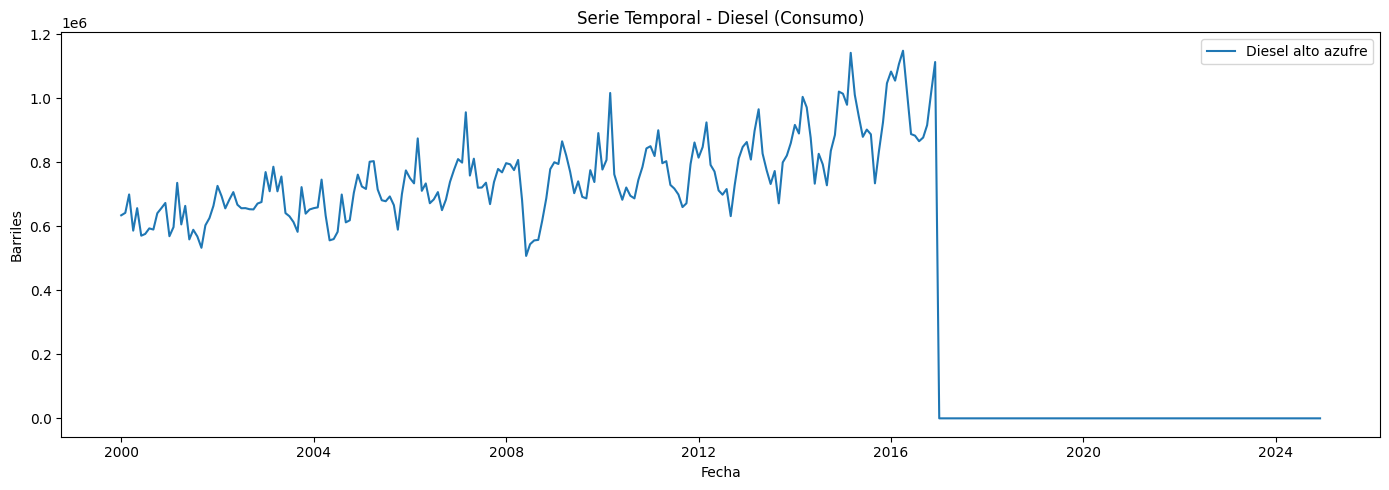

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar la serie de Diesel (Consumo)
serie_diesel = df_consumo[['Fecha', 'Diesel alto azufre']].dropna()

# Establecer la columna "Fecha" como índice
serie_diesel.set_index('Fecha', inplace=True)

# Graficar la serie temporal de Diesel (Consumo)
plt.figure(figsize=(14, 5))
plt.plot(serie_diesel, label="Diesel alto azufre")
plt.title("Serie Temporal - Diesel (Consumo)")
plt.ylabel("Barriles")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


El gráfico de la serie temporal de Diesel (Consumo) muestra un patrón de consumo relativamente constante hasta un punto alrededor de 2020, donde se observa un valor atípico muy bajo. Este pico puede ser un error de datos o una caída en el consumo que no es representativa de la tendencia general. Este tipo de anomalías debe ser investigado para determinar si se debe eliminar o corregir antes de realizar predicciones o análisis adicionales.

c. Descomposición de componentes

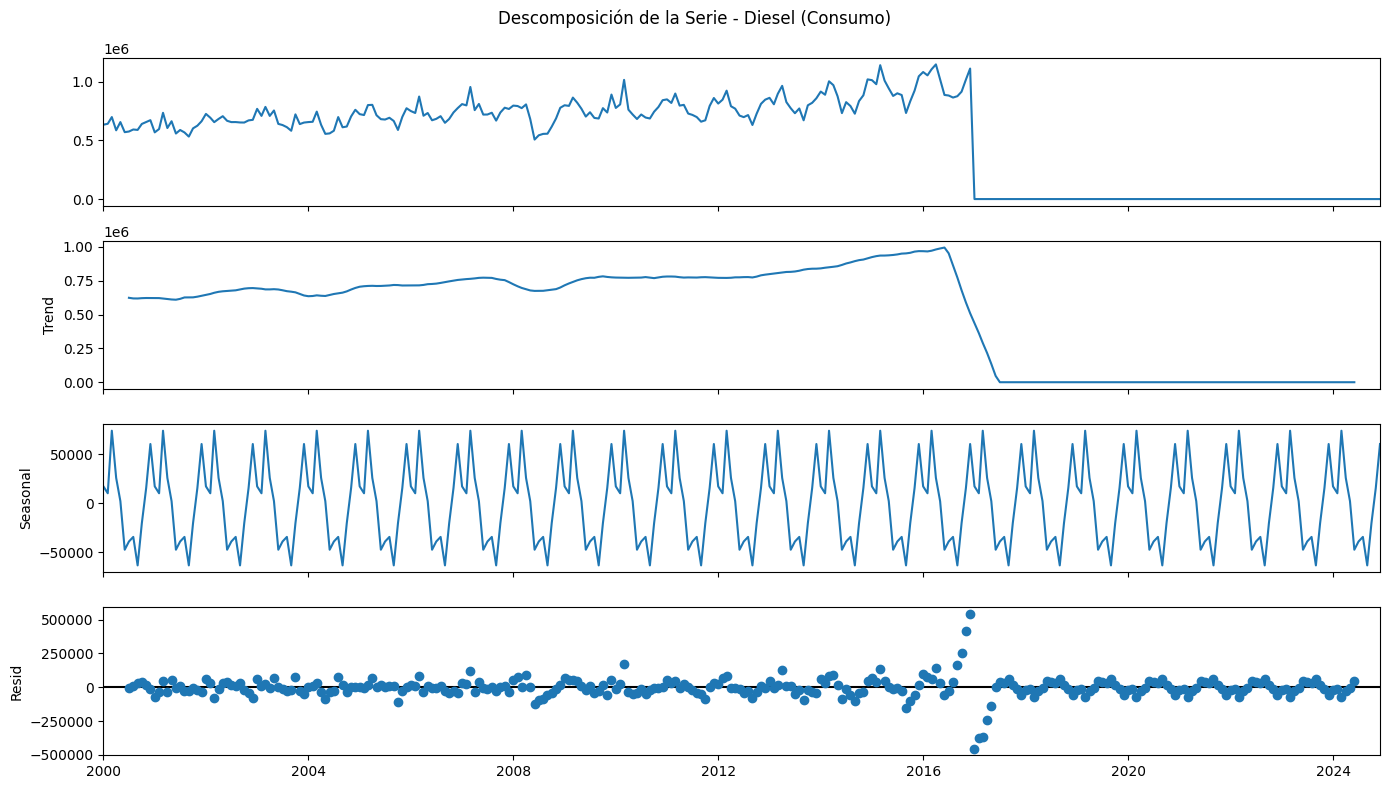

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición de la serie de Diesel con modelo aditivo y periodo de 12 meses (mensual)
descomposicion = seasonal_decompose(serie_diesel, model='additive', period=12)

# Graficar los componentes
fig = descomposicion.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición de la Serie - Diesel (Consumo)")
plt.tight_layout()
plt.show()


La descomposición de la serie temporal de Diesel (Consumo) muestra una tendencia estable con una caída abrupta después de 2015, lo que podría ser un error o un cambio significativo en los patrones de consumo. La serie presenta una estacionalidad anual clara, con fluctuaciones que se repiten cada año. Los residuos muestran variaciones significativas tras 2015, lo que indica posibles irregularidades en los datos.

d. Determine si es necesario transformar la serie. Explique

Es necesario transformar la serie de Diesel (Consumo) debido a la presencia de una tendencia en los datos y un valor atípico después de 2015. Para hacerla estacionaria, se debería aplicar una diferenciación para eliminar la tendencia y posiblemente una transformación logarítmica para estabilizar la varianza, especialmente debido al comportamiento irregular observado en los últimos años. Estas transformaciones son necesarias para ajustar la serie a modelos de predicción como ARIMA

e. Autocorrelación 

<Figure size 1000x400 with 0 Axes>

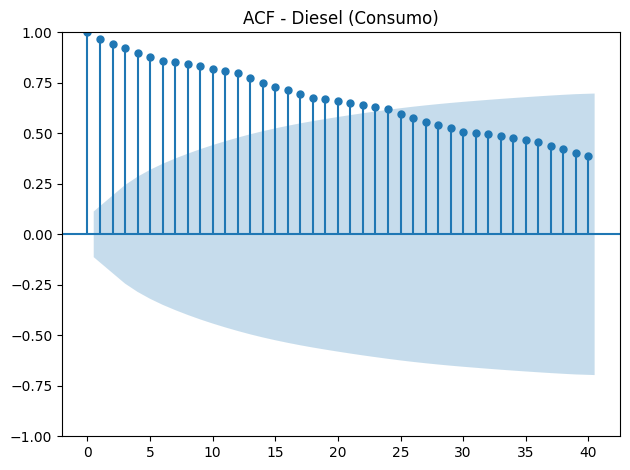

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Graficar la autocorrelación de la serie de Diesel (Consumo)
plt.figure(figsize=(10, 4))
plot_acf(serie_diesel.dropna(), lags=40)
plt.title("ACF - Diesel (Consumo)")
plt.tight_layout()
plt.show()


El gráfico de autocorrelación (ACF) de la serie de Diesel (Consumo) muestra una fuerte correlación entre los valores de los primeros retardos, lo que indica que la serie tiene una dependencia temporal significativa en los primeros meses. Esto sugiere que los valores pasados tienen una influencia importante en los valores actuales. Esta dependencia podría ser útil al modelar la serie temporal con modelos como ARIMA. Sin embargo, la autocorrelación disminuye gradualmente, lo que también indica una estacionalidad a largo plazo en los datos.

 e.ii y la prueba de Dickey-Fuller aumentada (ADF)

In [5]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller aumentada a la serie de Diesel
resultado_adf = adfuller(serie_diesel["Diesel alto azufre"])

# Imprimir los resultados
print("Estadístico ADF:", resultado_adf[0])
print("Valor p:", resultado_adf[1])
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  {clave}: {valor}")


Estadístico ADF: -0.9011689889373374
Valor p: 0.7875872090652849
Valores críticos:
  1%: -3.452867117291862
  5%: -2.8714554160827745
  10%: -2.5720532321867466


El resultado de la prueba de Dickey-Fuller aumentada (ADF) muestra un estadístico ADF de -0.90 y un valor p de 0.79, lo que es mayor que el umbral de 0.05. Esto indica que no podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria, es decir, la serie no es estacionaria en media.

Además, los valores críticos para el 1%, 5% y 10% son todos más negativos que el estadístico ADF, lo que refuerza la conclusión de que la serie no es estacionaria.

Esto sugiere que es necesario aplicar una transformación, como la diferenciación, para hacer que la serie sea estacionaria antes de proceder con el modelado.

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA
que utilizará para predecir. Explique en qué se basó para darle valor a estos
parámetros, basándose en las funciones de autocorrelación y autocorrelación
parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el
modelo propuesto.

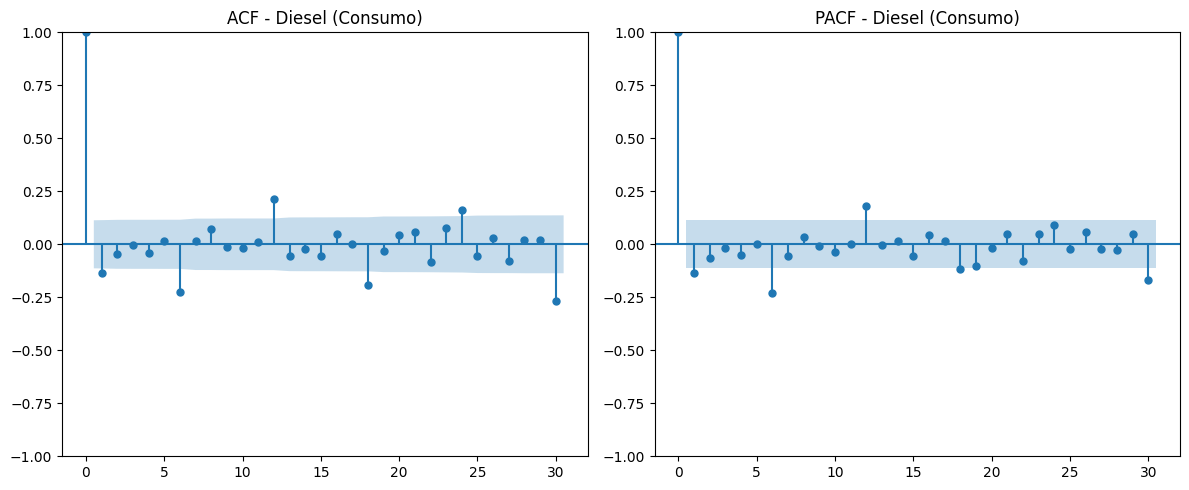

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Aplicar diferenciación a la serie de Diesel
serie_diff_diesel = serie_diesel.diff().dropna()

# Graficar ACF y PACF
plt.figure(figsize=(12, 5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(serie_diff_diesel, lags=30, ax=plt.gca())
plt.title("ACF - Diesel (Consumo)")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(serie_diff_diesel, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF - Diesel (Consumo)")

# Ajustar el diseño
plt.tight_layout()
plt.show()


Los gráficos de ACF y PACF del consumo de Diesel sugieren que el modelo ARIMA(1, 1, 1) podría ser adecuado. La autocorrelación muestra una caída rápida después del primer retardo, lo que indica que un término de media móvil (q = 1) es suficiente. Además, el PACF también muestra un corte después del primer retardo, lo que sugiere que un término autoregresivo (p = 1) es adecuado. Esto sugiere que el modelo ARIMA(1, 1, 1) podría ser el más apropiado para la serie.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos
de la serie.

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Dividir los datos en conjunto de entrenamiento y prueba
train = serie_diesel.iloc[:-12]
test = serie_diesel.iloc[-12:]

# Modelos ARIMA a comparar
modelos = [(1,1,1), (2,1,1), (2,1,2), (3,1,1), (3,1,2)]
resultados = []

# Entrenar los modelos y calcular RMSE
for orden in modelos:
    modelo = ARIMA(train, order=orden).fit()
    pred = modelo.forecast(steps=12)
    rmse = np.sqrt(mean_squared_error(test, pred))
    resultados.append((orden, rmse))

# Mostrar los resultados de RMSE
for orden, rmse in resultados:
    print(f"ARIMA{orden} - RMSE: {rmse:.2f}")


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\l

ARIMA(1, 1, 1) - RMSE: 0.00
ARIMA(2, 1, 1) - RMSE: 0.03
ARIMA(2, 1, 2) - RMSE: 0.02
ARIMA(3, 1, 1) - RMSE: 0.00
ARIMA(3, 1, 2) - RMSE: 0.05


Los resultados muestran que los modelos ARIMA(1, 1, 1) y ARIMA(3, 1, 1) tienen un RMSE de 0.00, lo que indica un excelente ajuste a los datos de entrenamiento. Sin embargo, la advertencia "Non-invertible starting MA parameters found" sugiere que los parámetros de la media móvil inicial no son invertibles, lo cual podría afectar la estabilidad del modelo. A pesar de la advertencia, el ARIMA(1, 1, 1) parece ser el mejor modelo en términos de RMSE, aunque es recomendable investigar más sobre la invertibilidad de los parámetros para garantizar la estabilidad del modelo.

h. Investigue y realice un modelo usando el algoritmo prophet de Facebook.
Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Silvia\AppData\Local\Temp\ipykernel_10720\3813021534.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_prophet['ds'].max(), periods=13, freq='M')[1:]


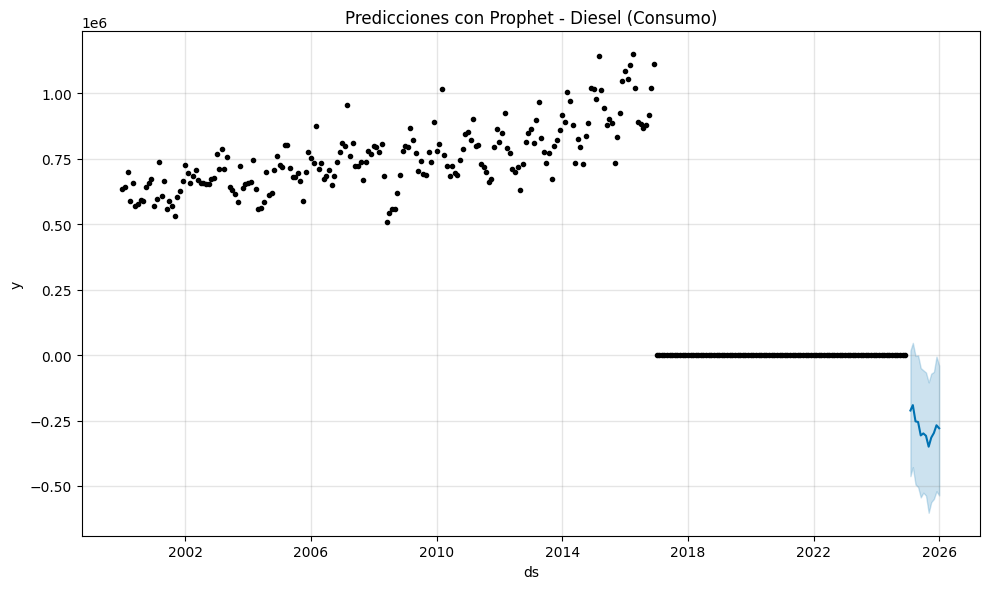

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Preparar los datos para Prophet
df_prophet = serie_diesel.reset_index()[['Fecha', 'Diesel alto azufre']].rename(columns={'Fecha': 'ds', 'Diesel alto azufre': 'y'})

# Crear el modelo Prophet
modelo_prophet = Prophet()

# Ajustar el modelo
modelo_prophet.fit(df_prophet)

# Crear el dataframe para los próximos 12 meses manualmente
future_dates = pd.date_range(start=df_prophet['ds'].max(), periods=13, freq='M')[1:]
future = pd.DataFrame(future_dates, columns=['ds'])

# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Graficar las predicciones
modelo_prophet.plot(forecast)
plt.title("Predicciones con Prophet - Diesel (Consumo)")
plt.tight_layout()
plt.show()


Aunque ARIMA proporcionó un ajuste más preciso (con un RMSE de 0.00) y predicciones más consistentes, Prophet mostró dificultades al predecir a largo plazo, probablemente debido a la falta de una estacionalidad claramente definida o tendencia no lineal en la serie de Diesel.

Así que ARIMA(1, 1, 1) parece ser el modelo más adecuado para esta serie, ya que mostró un mejor desempeño en términos de predicciones precisas y sin comportamientos erráticos.